#### **Flags**

In [2]:
already_loaded = True
transformed = True
trained_knn = True
trained_svm = True
trained_mlp = True
trained_cnn_125x94 = True
resized_32x32 = True
trained_cnn_resized = True
extracted_hog = True
hog_pca_transformed = True
trained_hog_svm = True
trained_mlp_hog = True
trained_mlp_hog_pca = True
extracted_lbp = True
lbp_pca_transformed = True
trained_lbp_svm = True
trained_mlp_lbp_pca = True
extracted_resnet = True
resnet_pca_transformed = True
trained_resnet_svm = True
trained_resnet_knn = True
trained_mlp_resnet = True
trained_mlp_resnet_pca = True

#### **Imports**

In [3]:
from joblib import dump, load
import numpy as np

from sklearn.datasets import fetch_lfw_people

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from skimage.feature import hog
from skimage.feature import local_binary_pattern

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt

#### **Loading Dataset**

In [4]:
if not already_loaded:
    
    # Load the LFW dataset in color with original image size
    lfw_people = fetch_lfw_people(color=True, resize=None, min_faces_per_person=20)

    # fetch grayscale iamges
    lfw_people_gray = fetch_lfw_people(color=False, resize=None, min_faces_per_person=20)
    X_gray = lfw_people_gray.data
    y_gray = lfw_people_gray.target
    dump(lfw_people_gray, 'lfw_dataset_gray.joblib')

    n_samples, h, w, c = lfw_people.images.shape

    X = lfw_people.data
    n_features = X.shape[1]

    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print(f"Image dimensions: {h} x {w} x {c}")
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)

    dump(lfw_people, 'lfw_dataset.joblib')

else:
    # Load the dataset from the saved file
    lfw_people = load('lfw_dataset.joblib')

    lfw_people_gray = load('lfw_dataset_gray.joblib')
    X_gray = lfw_people_gray.data
    y_gray = lfw_people_gray.target

    n_samples, h, w, c = lfw_people.images.shape

    X = lfw_people.data
    n_features = X.shape[1]

    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print(f"Image dimensions: {h} x {w} x {c}")
    print("n_features: %d" % n_features)
    print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 3023
Image dimensions: 125 x 94 x 3
n_features: 35250
n_classes: 62


In [5]:
if not resized_32x32:

    # Load the LFW dataset in color with original image size
    lfw_people_orig = fetch_lfw_people(color=True, resize=0.35, min_faces_per_person=20)

    n_samples_orig, h_orig, w_orig, c_orig = lfw_people_orig.images.shape

    X_orig = lfw_people_orig.data
    n_features_orig = X_orig.shape[1]

    y_orig = lfw_people_orig.target
    target_names_orig = lfw_people_orig.target_names
    n_classes_orig = target_names_orig.shape[0]

    # Reshape images
    X_reshaped = lfw_people_orig.images.reshape(n_samples_orig, h_orig, w_orig, c_orig)

    # Crop images
    crop_top = int((h_orig - 32) / 2)
    crop_bottom = h_orig - 32 - crop_top
    lfw_people_cropped = X_reshaped[:, crop_top:-crop_bottom, :, :]

    # Reshape again after cropping
    n_samples, h_resized, w_resized, c = lfw_people_cropped.shape
    X_resized = lfw_people_cropped.reshape(n_samples, -1)
    n_features_resized = X_resized.shape[1]
    y = y_orig
    target_names = target_names_orig
    n_classes = n_classes_orig

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print(f"Image dimensions: {h_resized} x {w_resized} x {c}")
    print("n_features: %d" % n_features_resized)
    print("n_classes: %d" % n_classes)

    dump(lfw_people_cropped, 'lfw_dataset_resized_cropped.joblib')

else:
    # Load the dataset from the saved file
    lfw_people_cropped = load('lfw_dataset_resized_cropped.joblib')

    n_samples, h_resized, w_resized, c = lfw_people_cropped.shape

    X_resized = lfw_people_cropped.reshape(n_samples, -1)
    n_features_resized = X_resized.shape[1]

    y = lfw_people.target
    target_names = lfw_people.target_names
    n_classes = target_names.shape[0]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print(f"Image dimensions: {h_resized} x {w_resized} x {c}")
    print("n_features: %d" % n_features_resized)
    print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 3023
Image dimensions: 32 x 32 x 3
n_features: 3072
n_classes: 62


#### **Train Test Split**

In [6]:
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

In [7]:
# Split data into train, validation, and test sets
X_train_val_gray, X_test_gray, y_train_val_gray, y_test_gray = train_test_split(X_gray, y_gray, test_size=0.2, random_state=42, stratify=y_gray)
X_train_gray, X_val_gray, y_train_gray, y_val_gray = train_test_split(X_train_val_gray, y_train_val_gray, test_size=0.125, random_state=42, stratify=y_train_val_gray)

In [8]:
# Split data into train, validation, and test sets
X_train_val_resized, X_test_resized, y_train_val, y_test = train_test_split(X_resized, y, test_size=0.2, random_state=42, stratify=y)
X_train_resized, X_val_resized, y_train, y_val = train_test_split(X_train_val_resized, y_train_val, test_size=0.125, random_state=42, stratify=y_train_val)

The variables are named as such only for convenience. There is **no oversampling done** in this notebook.

In [9]:
X_train_resampled_smote, y_train_resampled_smote = X_train, y_train
X_train_gray_resampled_smote, y_train_gray_resampled_smote = X_train_gray, y_train_gray
X_train_resampled_smote_resized, y_train_resampled_smote_resized = X_train_resized, y_train

#### **PCA Transform**

In [10]:
if not transformed:

    # Perform PCA after oversampling
    pca_smote = PCA(n_components=100)

    pca_smote_gray = PCA(n_components=100)

    pca_smote_resized = PCA(n_components=100)


    X_train_pca_smote = pca_smote.fit_transform(X_train_resampled_smote)

    X_val_pca_smote = pca_smote.transform(X_val)
    X_test_pca_smote = pca_smote.transform(X_test)

    X_train_gray_pca_smote = pca_smote_gray.fit_transform(X_train_gray_resampled_smote)

    X_val_gray_pca_smote = pca_smote_gray.transform(X_val_gray)
    X_test_gray_pca_smote = pca_smote_gray.transform(X_test_gray)

    X_train_pca_smote_resized = pca_smote_resized.fit_transform(X_train_resampled_smote_resized)

    X_val_pca_smote_resized = pca_smote_resized.transform(X_val_resized)
    X_test_pca_smote_resized = pca_smote_resized.transform(X_test_resized)

    # Save the transformed data
    dump(X_train_pca_smote, 'X_train_pca_smote.joblib')
    dump(X_val_pca_smote, 'X_val_pca_smote.joblib')
    dump(X_test_pca_smote, 'X_test_pca_smote.joblib')

    dump(X_train_gray_pca_smote, 'X_train_gray_pca_smote.joblib')
    dump(X_val_gray_pca_smote, 'X_val_gray_pca_smote.joblib')
    dump(X_test_gray_pca_smote, 'X_test_gray_pca_smote.joblib')

    dump(X_train_pca_smote_resized, 'X_train_pca_smote_resized.joblib')
    dump(X_val_pca_smote_resized, 'X_val_pca_smote_resized.joblib')
    dump(X_test_pca_smote_resized, 'X_test_pca_smote_resized.joblib')

else:

    # Save the transformed data
    X_train_pca_smote = load('X_train_pca_smote.joblib')
    X_val_pca_smote = load('X_val_pca_smote.joblib')
    X_test_pca_smote = load('X_test_pca_smote.joblib')

    X_train_gray_pca_smote = load('X_train_gray_pca_smote.joblib')
    X_val_gray_pca_smote = load('X_val_gray_pca_smote.joblib')
    X_test_gray_pca_smote = load('X_test_gray_pca_smote.joblib')

    X_train_pca_smote_resized = load('X_train_pca_smote_resized.joblib')
    X_val_pca_smote_resized = load('X_val_pca_smote_resized.joblib')
    X_test_pca_smote_resized = load('X_test_pca_smote_resized.joblib')

#### **KNN**

In [11]:
if not trained_knn:

    # Define kNN classifier
    knn = KNeighborsClassifier()

    # Define parameter grid for grid search
    knn_param_grid = {'n_neighbors': [1, 3, 5, 7]} 

    # Perform grid search for kNN
    knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5)
    knn_grid_search.fit(X_train_pca_smote, y_train_resampled_smote)

    # Get best hyperparameters for kNN
    best_knn_params = knn_grid_search.best_params_

    # Train kNN classifier with best hyperparameters
    best_knn = KNeighborsClassifier(**best_knn_params)
    best_knn.fit(X_train_pca_smote, y_train_resampled_smote)

    # Save the trained kNN model
    dump(best_knn, 'best_knn_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_knn = best_knn.predict(X_train_pca_smote)
    val_pred_knn = best_knn.predict(X_val_pca_smote)
    test_pred_knn = best_knn.predict(X_test_pca_smote)

    # Calculate accuracies
    train_accuracy_knn = accuracy_score(y_train_resampled_smote, train_pred_knn)
    val_accuracy_knn = accuracy_score(y_val, val_pred_knn)
    test_accuracy_knn = accuracy_score(y_test, test_pred_knn)

    # Print accuracies
    print("kNN:")
    print(f"Best params: {best_knn_params}")
    print(f"Train Accuracy: {train_accuracy_knn}")
    print(f"Validation Accuracy: {val_accuracy_knn}")
    print(f"Test Accuracy: {test_accuracy_knn}")

else:

    # Load the saved kNN model
    best_knn = load('best_knn_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_knn = best_knn.predict(X_train_pca_smote)
    val_pred_knn = best_knn.predict(X_val_pca_smote)
    test_pred_knn = best_knn.predict(X_test_pca_smote)

    # Calculate accuracies
    train_accuracy_knn = accuracy_score(y_train_resampled_smote, train_pred_knn)
    val_accuracy_knn = accuracy_score(y_val, val_pred_knn)
    test_accuracy_knn = accuracy_score(y_test, test_pred_knn)

    # Print accuracies
    print("kNN:")
    # print(f"Best params: {best_knn_params}")
    print(f"Train Accuracy: {train_accuracy_knn}")
    print(f"Validation Accuracy: {val_accuracy_knn}")
    print(f"Test Accuracy: {test_accuracy_knn}")

kNN:
Train Accuracy: 1.0
Validation Accuracy: 0.29372937293729373
Test Accuracy: 0.31239669421487604


#### **SVM**

In [12]:
if not trained_svm:

    # Define SVM classifier
    svm = SVC()

    # Define parameter grid for grid search
    svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]} 

    # Perform grid search for SVM
    svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5)
    svm_grid_search.fit(X_train_pca_smote, y_train_resampled_smote)

    # Get best hyperparameters for SVM
    best_svm_params = svm_grid_search.best_params_

    # Train SVM classifier with best hyperparameters
    best_svm = SVC(**best_svm_params)
    best_svm.fit(X_train_pca_smote, y_train_resampled_smote)

    # Save the trained SVM model
    dump(best_svm, 'best_svm_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm = best_svm.predict(X_train_pca_smote)
    val_pred_svm = best_svm.predict(X_val_pca_smote)
    test_pred_svm = best_svm.predict(X_test_pca_smote)

    # Calculate accuracies
    train_accuracy_svm = accuracy_score(y_train_resampled_smote, train_pred_svm)
    val_accuracy_svm = accuracy_score(y_val, val_pred_svm)
    test_accuracy_svm = accuracy_score(y_test, test_pred_svm)

    # Print accuracies
    print("SVM:")
    print(f"Best params: {best_svm_params}")
    print(f"Train Accuracy: {train_accuracy_svm}")
    print(f"Validation Accuracy: {val_accuracy_svm}")
    print(f"Test Accuracy: {test_accuracy_svm}")

else:
    
    # Load the saved SVM model
    best_svm = load('best_svm_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm = best_svm.predict(X_train_pca_smote)
    val_pred_svm = best_svm.predict(X_val_pca_smote)
    test_pred_svm = best_svm.predict(X_test_pca_smote)

    # Calculate accuracies
    train_accuracy_svm = accuracy_score(y_train_resampled_smote, train_pred_svm)
    val_accuracy_svm = accuracy_score(y_val, val_pred_svm)
    test_accuracy_svm = accuracy_score(y_test, test_pred_svm)

    # Print accuracies
    print("SVM:")
    # print(f"Best params: {best_svm_params}")
    print(f"Train Accuracy: {train_accuracy_svm}")
    print(f"Validation Accuracy: {val_accuracy_svm}")
    print(f"Test Accuracy: {test_accuracy_svm}")

SVM:
Train Accuracy: 0.9985815602836879
Validation Accuracy: 0.5676567656765676
Test Accuracy: 0.5553719008264463


#### **Device, tensors & Dataloaders**

In [13]:
# Check if GPU is available
# device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


##### **For MLP**

In [14]:
X_train_tensor_pca = torch.tensor(X_train_pca_smote, dtype=torch.float32).to(device)
y_train_tensor_pca = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_pca = torch.tensor(X_val_pca_smote, dtype=torch.float32).to(device)
y_val_tensor_pca = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_pca = torch.tensor(X_test_pca_smote, dtype=torch.float32).to(device)
y_test_tensor_pca = torch.tensor(y_test, dtype=torch.long).to(device)

In [15]:
train_dataset_pca = TensorDataset(X_train_tensor_pca, y_train_tensor_pca)
train_loader_pca = DataLoader(train_dataset_pca, batch_size=64, shuffle=True)

val_dataset_pca = TensorDataset(X_val_tensor_pca, y_val_tensor_pca)
val_loader_pca = DataLoader(val_dataset_pca, batch_size=64, shuffle=True)

test_dataset_pca = TensorDataset(X_test_tensor_pca, y_test_tensor_pca)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=64, shuffle=True)

In [16]:
X_train_tensor_pca_resized = torch.tensor(X_train_pca_smote_resized, dtype=torch.float32).to(device)
y_train_tensor_pca_resized = torch.tensor(y_train_resampled_smote_resized, dtype=torch.long).to(device)
X_val_tensor_pca_resized = torch.tensor(X_val_pca_smote_resized, dtype=torch.float32).to(device)
y_val_tensor_pca_resized = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_pca_resized = torch.tensor(X_test_pca_smote_resized, dtype=torch.float32).to(device)
y_test_tensor_pca_resized = torch.tensor(y_test, dtype=torch.long).to(device)

In [17]:
train_dataset_pca_resized = TensorDataset(X_train_tensor_pca_resized, y_train_tensor_pca_resized)
train_loader_pca_resized = DataLoader(train_dataset_pca_resized, batch_size=64, shuffle=True)

val_dataset_pca_resized = TensorDataset(X_val_tensor_pca_resized, y_val_tensor_pca_resized)
val_loader_pca_resized = DataLoader(val_dataset_pca, batch_size=64, shuffle=True)

test_dataset_pca_resized = TensorDataset(X_test_tensor_pca_resized, y_test_tensor_pca_resized)
test_loader_pca_resized = DataLoader(test_dataset_pca_resized, batch_size=64, shuffle=True)

##### **For CNN**

In [18]:
X_train_resampled_smote_3d = X_train_resampled_smote.reshape(-1, 3, 125, 94)
X_val_3d = X_val.reshape(-1, 3, 125, 94)
X_test_3d = X_test.reshape(-1, 3, 125, 94)

In [19]:
X_train_gray_resampled_smote_2d = X_train_gray_resampled_smote.reshape(-1, 125, 94)
X_val_gray_2d = X_val_gray.reshape(-1, 125, 94)
X_test_gray_2d = X_test_gray.reshape(-1, 125, 94)

In [20]:
X_train_resampled_smote_3d_resized = X_train_resampled_smote_resized.reshape(-1, 3, 32, 32)
X_val_3d_resized = X_val_resized.reshape(-1, 3, 32, 32)
X_test_3d_resized = X_test_resized.reshape(-1, 3, 32, 32)

##### **Flattened**

In [21]:
X_train_tensor = torch.tensor(X_train_resampled_smote, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [22]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [23]:
X_train_tensor_resized = torch.tensor(X_train_resampled_smote_resized, dtype=torch.float32).to(device)
y_train_tensor_resized = torch.tensor(y_train_resampled_smote_resized, dtype=torch.long).to(device)
X_val_tensor_resized = torch.tensor(X_val_resized, dtype=torch.float32).to(device)
y_val_tensor_resized = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_resized = torch.tensor(X_test_resized, dtype=torch.float32).to(device)
y_test_tensor_resized = torch.tensor(y_test, dtype=torch.long).to(device)

In [24]:
train_dataset_resized = TensorDataset(X_train_tensor_resized, y_train_tensor_resized)
train_loader_resized = DataLoader(train_dataset_resized, batch_size=64, shuffle=True)

val_dataset_resized = TensorDataset(X_val_tensor_resized, y_val_tensor_resized)
val_loader_resized = DataLoader(val_dataset_resized, batch_size=64, shuffle=True)

test_dataset_resized = TensorDataset(X_test_tensor_resized, y_test_tensor_resized)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=64, shuffle=True)

##### **3D**

In [25]:
X_train_tensor_3d = torch.tensor(X_train_resampled_smote_3d, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_3d = torch.tensor(X_val_3d, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_3d = torch.tensor(X_test_3d, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [26]:
train_dataset_3d = TensorDataset(X_train_tensor_3d, y_train_tensor)
train_loader_3d = DataLoader(train_dataset_3d, batch_size=64, shuffle=True)

val_dataset_3d = TensorDataset(X_val_tensor_3d, y_val_tensor)
val_loader_3d = DataLoader(val_dataset_3d, batch_size=64, shuffle=True)

test_dataset_3d = TensorDataset(X_test_tensor_3d, y_test_tensor)
test_loader_3d = DataLoader(test_dataset_3d, batch_size=64, shuffle=True)

In [27]:
X_train_tensor_3d_resized = torch.tensor(X_train_resampled_smote_3d_resized, dtype=torch.float32).to(device)
y_train_tensor_resized = torch.tensor(y_train_resampled_smote_resized, dtype=torch.long).to(device)
X_val_tensor_3d_resized = torch.tensor(X_val_3d_resized, dtype=torch.float32).to(device)
y_val_tensor_resized = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_3d_resized = torch.tensor(X_test_3d_resized, dtype=torch.float32).to(device)
y_test_tensor_resized = torch.tensor(y_test, dtype=torch.long).to(device)

In [28]:
train_dataset_3d_resized = TensorDataset(X_train_tensor_3d_resized, y_train_tensor_resized)
train_loader_3d_resized = DataLoader(train_dataset_3d_resized, batch_size=64, shuffle=True)

val_dataset_3d_resized = TensorDataset(X_val_tensor_3d_resized, y_val_tensor_resized)
val_loader_3d_resized = DataLoader(val_dataset_3d_resized, batch_size=64, shuffle=True)

test_dataset_3d_resized = TensorDataset(X_test_tensor_3d_resized, y_test_tensor_resized)
test_loader_3d_resized = DataLoader(test_dataset_3d_resized, batch_size=64, shuffle=True)

#### **MLP**

In [29]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model_mlp(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    model = model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        # Calculate training loss and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        
        # Calculate validation loss and accuracy
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        
        # Print training and validation loss and accuracy for each epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {100 * train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {100 * val_accuracy:.2f}%')
        
    # Plotting training and validation accuracies
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.show()

def eval_mlp_model(mlp_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor, should_return=False):

    mlp_model.eval()
    with torch.no_grad():
        train_outputs = mlp_model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), train_predicted.cpu().numpy())
        print("Train Accuracy:", train_accuracy)

        val_outputs = mlp_model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predicted.cpu().numpy())
        print("Validation Accuracy:", val_accuracy)

        test_outputs = mlp_model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predicted.cpu().numpy())
        print("Test Accuracy:", test_accuracy)

    if should_return:
        return train_predicted, val_predicted, test_predicted   

In [30]:
input_size = X_train_tensor_pca.shape[1]
hidden_size = 128
output_size = len(torch.unique(y_train_tensor_pca))
mlp_model_pca = MLPClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_pca.parameters(), lr=0.001)

In [31]:
if not trained_mlp:

    train_model_mlp(mlp_model_pca, train_loader_pca, val_loader_pca, criterion, optimizer, device, num_epochs=15)

    eval_mlp_model(mlp_model_pca, X_train_tensor_pca, y_train_tensor_pca, X_val_tensor_pca, y_val_tensor_pca, X_test_tensor_pca, y_test_tensor_pca)

    dump(mlp_model_pca, 'mlp_model_pca.joblib')

else:

    mlp_model_pca = load('mlp_model_pca.joblib')
    train_pred_mlp, val_pred_mlp, test_pred_mlp = eval_mlp_model(mlp_model_pca, X_train_tensor_pca, y_train_tensor_pca, X_val_tensor_pca, y_val_tensor_pca, X_test_tensor_pca, y_test_tensor_pca, should_return=True)

Train Accuracy: 0.9531914893617022
Validation Accuracy: 0.6402640264026402
Test Accuracy: 0.596694214876033


In [32]:
input_size_resized = X_train_tensor_pca_resized.shape[1]
hidden_size_resized = 128
output_size_resized = len(torch.unique(y_train_tensor_pca_resized))
mlp_model_pca_resized = MLPClassifier(input_size_resized, hidden_size_resized, output_size_resized).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_pca_resized.parameters(), lr=0.001)

In [33]:
if not trained_mlp:
    
    train_model_mlp(mlp_model_pca_resized, train_loader_pca_resized, val_loader_pca_resized, criterion, optimizer, device, num_epochs=10)

    eval_mlp_model(mlp_model_pca_resized, X_train_tensor_pca_resized, y_train_tensor_pca_resized, X_val_tensor_pca_resized, y_val_tensor_pca_resized, X_test_tensor_pca_resized, y_test_tensor_pca_resized)

    dump(mlp_model_pca_resized, 'mlp_model_pca_resized.joblib')

else:

    mlp_model_pca_resized = load('mlp_model_pca_resized.joblib')
    train_pred_mlp_resized, val_pred_mlp_resized, test_pred_mlp_resized = eval_mlp_model(mlp_model_pca_resized, X_train_tensor_pca_resized, y_train_tensor_pca_resized, X_val_tensor_pca_resized, y_val_tensor_pca_resized, X_test_tensor_pca_resized, y_test_tensor_pca_resized, should_return=True)

Train Accuracy: 0.6614657210401891
Validation Accuracy: 0.49174917491749176
Test Accuracy: 0.44958677685950416


#### **Regularized MLP**

In [34]:
# Define the MLP model with regularization
class RegularizedMLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5, weight_decay=1e-5):
        super(RegularizedMLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.weight_decay = weight_decay

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Define training function with regularization
def train_model_mlp_reg(model, train_loader, X_val_tensor, y_val_tensor, criterion, optimizer, device, num_epochs=10):

    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):

        model.train()
        total_correct = 0
        total_samples = 0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # L2 regularization
            l2_reg = 0

            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += model.weight_decay * l2_reg
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
        
        train_accuracy = total_correct / total_samples
        train_accuracies.append(train_accuracy)
        
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            outputs = model(X_val_tensor)
            _, predicted = torch.max(outputs, 1)
            val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), predicted.cpu().numpy())
            val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Plotting training and validation accuracies
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.show()


In [35]:
input_size = X_train_tensor_pca.shape[1]
hidden_size = 128
output_size = len(torch.unique(y_train_tensor_pca))
reg_mlp_model_pca = RegularizedMLPClassifier(input_size, hidden_size, output_size).to(device)
# Set up criterion, optimizer, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(reg_mlp_model_pca.parameters(), lr=0.001)
num_epochs = 30

In [36]:
if not trained_mlp:
    # Train the model with regularization
    train_model_mlp_reg(reg_mlp_model_pca, train_loader_pca, X_val_tensor_pca, y_val_tensor_pca, criterion, optimizer, device, num_epochs)

In [37]:
input_size_resized = X_train_tensor_pca_resized.shape[1]
hidden_size_resized = 128
output_size_resized = len(torch.unique(y_train_tensor_pca_resized))
reg_mlp_model_pca_resized = RegularizedMLPClassifier(input_size_resized, hidden_size_resized, output_size_resized).to(device)
# Set up criterion, optimizer, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(reg_mlp_model_pca_resized.parameters(), lr=0.001)
num_epochs = 30

In [38]:
if not trained_mlp:
    train_model_mlp_reg(reg_mlp_model_pca_resized, train_loader_pca_resized, X_val_tensor_pca_resized, y_val_tensor_pca_resized, criterion, optimizer, device, num_epochs)

#### **HOG**

In [44]:
class HOGFeatureExtractor:
    def __init__(self, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
    
    def extract_features(self, images):

        hog_features = []
        hog_images = []

        for image in images:

            # Compute HOG features and visualization
            features, hog_image = hog(image, orientations=self.orientations, 
                                      pixels_per_cell=self.pixels_per_cell,
                                      cells_per_block=self.cells_per_block, 
                                      visualize=True, transform_sqrt=True)
            hog_features.append(features)
            hog_images.append(hog_image)
        return np.array(hog_features), np.array(hog_images)

    def prepare_data(self, data):
        features, hog_images = self.extract_features(data)
        # Normalize features
        features = np.array(features)
        features = features / np.linalg.norm(features, axis=1)[:, None]
        return features, hog_images

In [45]:
if not extracted_hog:
    
    hog_extractor = HOGFeatureExtractor(orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

    X_train_hog_features, X_train_hog_images = hog_extractor.prepare_data(X_train_gray_resampled_smote_2d)
    X_val_hog_features, X_val_hog_images = hog_extractor.prepare_data(X_val_gray_2d)
    X_test_hog_features, X_test_hog_images = hog_extractor.prepare_data(X_test_gray_2d)

    dump(X_train_hog_features, 'X_train_hog_features.joblib')
    dump(X_val_hog_features, 'X_val_hog_features.joblib')
    dump(X_test_hog_features, 'X_test_hog_features.joblib')

else:
    X_train_hog_features = load('X_train_hog_features.joblib')
    X_val_hog_features = load('X_val_hog_features.joblib')
    X_test_hog_features = load('X_test_hog_features.joblib')

##### **PCA on hog features**

In [46]:
if not hog_pca_transformed:

    pca_hog = PCA(n_components=100)
    pca_hog_resized = PCA(n_components=100)

    X_train_hog_features_pca = pca_hog.fit_transform(X_train_hog_features)
    X_val_hog_features_pca = pca_hog.transform(X_val_hog_features)
    X_test_hog_features_pca = pca_hog.transform(X_test_hog_features)

    dump(X_train_hog_features_pca, 'X_train_hog_features_pca.joblib')
    dump(X_val_hog_features_pca, 'X_val_hog_features_pca.joblib')
    dump(X_test_hog_features_pca, 'X_test_hog_features_pca.joblib')

else:

    X_train_hog_features_pca = load('X_train_hog_features_pca.joblib')
    X_val_hog_features_pca = load('X_val_hog_features_pca.joblib')
    X_test_hog_features_pca = load('X_test_hog_features_pca.joblib')

##### **SVM on PCA transformed hog features**

In [47]:
if not trained_hog_svm:

    # Define SVM classifier
    svm_hog_pca = SVC()

    # Define parameter grid for grid search
    svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]} 

    # Perform grid search for SVM on PCA transformed hog features
    svm_grid_search_pca = GridSearchCV(svm_hog_pca, svm_param_grid, cv=5)
    svm_grid_search_pca.fit(X_train_hog_features_pca, y_train_resampled_smote)

    # Get best hyperparameters for SVM
    best_svm_params_hog_pca = svm_grid_search_pca.best_params_

    # Train SVM classifier with best hyperparameters
    best_svm_hog_pca = SVC(**best_svm_params_hog_pca)
    best_svm_hog_pca.fit(X_train_hog_features_pca, y_train_resampled_smote)

    # Save the trained SVM model
    dump(best_svm_hog_pca, 'best_svm_model_hog_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_hog_pca = best_svm_hog_pca.predict(X_train_hog_features_pca)
    val_pred_svm_hog_pca = best_svm_hog_pca.predict(X_val_hog_features_pca)
    test_pred_svm_hog_pca = best_svm_hog_pca.predict(X_test_hog_features_pca)

    # Calculate accuracies
    train_accuracy_svm_hog_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_hog_pca)
    val_accuracy_svm_hog_pca = accuracy_score(y_val, val_pred_svm_hog_pca)
    test_accuracy_svm_hog_pca = accuracy_score(y_test, test_pred_svm_hog_pca)

    # Print accuracies
    print("SVM(PCA):")
    print(f"Best params(PCA): {best_svm_params_hog_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_hog_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_hog_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_hog_pca}")

else:
    
    # Load the saved SVM model
    best_svm_hog_pca = load('best_svm_model_hog_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_hog_pca = best_svm_hog_pca.predict(X_train_hog_features_pca)
    val_pred_svm_hog_pca = best_svm_hog_pca.predict(X_val_hog_features_pca)
    test_pred_svm_hog_pca = best_svm_hog_pca.predict(X_test_hog_features_pca)

    # Calculate accuracies
    train_accuracy_svm_hog_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_hog_pca)
    val_accuracy_svm_hog_pca = accuracy_score(y_val, val_pred_svm_hog_pca)
    test_accuracy_svm_hog_pca = accuracy_score(y_test, test_pred_svm_hog_pca)

    # Print accuracies
    print("SVM(PCA):")
    # print(f"Best params(PCA): {best_svm_params_hog_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_hog_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_hog_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_hog_pca}")

SVM(PCA):
Train Accuracy(PCA): 1.0
Validation Accuracy(PCA): 0.7062706270627063
Test Accuracy(PCA): 0.6958677685950413


##### **MLP on HOG features**

In [48]:
X_train_tensor_hog_features = torch.tensor(X_train_hog_features, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_hog_features = torch.tensor(X_val_hog_features, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_hog_features = torch.tensor(X_test_hog_features, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [49]:
train_dataset_hog_features = TensorDataset(X_train_tensor_hog_features, y_train_tensor)
train_loader_hog_features = DataLoader(train_dataset_hog_features, batch_size=64, shuffle=True)

val_dataset_hog_features = TensorDataset(X_val_tensor_hog_features, y_val_tensor)
val_loader_hog_features = DataLoader(val_dataset_hog_features, batch_size=64, shuffle=True)

test_dataset_hog_features = TensorDataset(X_test_tensor_hog_features, y_test_tensor)
test_loader_hog_features = DataLoader(test_dataset_hog_features, batch_size=64, shuffle=True)

In [50]:
input_size = X_train_tensor_hog_features.shape[1]
hidden_size = 1024
output_size = len(torch.unique(y_train_tensor))
mlp_model_hog = MLPClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_hog.parameters(), lr=0.001)

In [51]:
if not trained_mlp_hog:

    train_model_mlp(mlp_model_hog, train_loader_hog_features, val_loader_hog_features, criterion, optimizer, device, num_epochs=25)

    eval_mlp_model(mlp_model_hog, X_train_tensor_hog_features, y_train_tensor, X_val_tensor_hog_features, y_val_tensor, X_test_tensor_hog_features, y_test_tensor)

    dump(mlp_model_hog, 'mlp_model_hog.joblib')

else:

    mlp_model_hog = load('mlp_model_hog.joblib')
    train_pred_mlp_hog, val_pred_mlp_hog, test_pred_mlp_hog = eval_mlp_model(mlp_model_hog, X_train_tensor_hog_features, y_train_tensor, X_val_tensor_hog_features, y_val_tensor, X_test_tensor_hog_features, y_test_tensor, should_return=True)

Train Accuracy: 0.9721040189125295
Validation Accuracy: 0.7227722772277227
Test Accuracy: 0.6793388429752066


##### **MLP on PCA transformed hog features**

In [52]:
X_train_tensor_hog_pca = torch.tensor(X_train_hog_features_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_hog_pca = torch.tensor(X_val_hog_features_pca, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_hog_pca = torch.tensor(X_test_hog_features_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [53]:
train_dataset_hog_pca = TensorDataset(X_train_tensor_hog_pca, y_train_tensor)
train_loader_hog_pca = DataLoader(train_dataset_hog_pca, batch_size=64, shuffle=True)

val_dataset_hog_pca = TensorDataset(X_val_tensor_hog_pca, y_val_tensor)
val_loader_hog_pca = DataLoader(val_dataset_hog_pca, batch_size=64, shuffle=True)

test_dataset_hog_pca = TensorDataset(X_test_tensor_hog_pca, y_test_tensor)
test_loader_hog_pca = DataLoader(test_dataset_hog_pca, batch_size=64, shuffle=True)

In [54]:
input_size = X_train_tensor_hog_pca.shape[1]
hidden_size = 256
output_size = len(torch.unique(y_train_tensor))
mlp_model_hog_pca = MLPClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_hog_pca.parameters(), lr=0.001)

In [55]:
if not trained_mlp_hog_pca:

    train_model_mlp(mlp_model_hog_pca, train_loader_hog_pca, val_loader_hog_pca, criterion, optimizer, device, num_epochs=40)

    eval_mlp_model(mlp_model_hog_pca, X_train_tensor_hog_pca, y_train_tensor, X_val_tensor_hog_pca, y_val_tensor, X_test_tensor_hog_pca, y_test_tensor)

    dump(mlp_model_hog_pca, 'mlp_model_hog_pca.joblib')

else:

    mlp_model_hog_pca = load('mlp_model_hog_pca.joblib')
    train_pred_mlp_hog_pca, val_pred_mlp_hog_pca, test_pred_mlp_hog_pca = eval_mlp_model(mlp_model_hog_pca, X_train_tensor_hog_pca, y_train_tensor, X_val_tensor_hog_pca, y_val_tensor, X_test_tensor_hog_pca, y_test_tensor, should_return=True)

Train Accuracy: 0.8250591016548463
Validation Accuracy: 0.66996699669967
Test Accuracy: 0.6363636363636364


#### **LBP**

In [56]:
class LBPFeatureExtractor:
    def __init__(self, radius=1, n_points=8, method='default'):
        self.radius = radius
        self.n_points = n_points
        self.method = method

    def extract_features(self, images):
        
        lbp_features = []
        lbp_images = []

        for image in images:

            # Compute LBP features and visualization
            lbp_image = local_binary_pattern(image, self.n_points, self.radius, method=self.method)
            lbp_features.append(lbp_image)
            lbp_images.append(lbp_image)

        return np.array(lbp_features), np.array(lbp_images)

    def prepare_data(self, data):
        features, lbp_images = self.extract_features(data)
        # Flatten LBP images to make them suitable for model input
        features = features.reshape(features.shape[0], -1)
        return features, lbp_images

In [57]:
if not extracted_lbp:

    lbp_extractor = LBPFeatureExtractor()

    X_train_lbp_features, X_train_lbp_images = lbp_extractor.prepare_data(X_train_gray_resampled_smote_2d)

    X_val_lbp_features, X_val_lbp_images = lbp_extractor.prepare_data(X_val_gray_2d)

    X_test_lbp_features, X_test_lbp_images = lbp_extractor.prepare_data(X_test_gray_2d)

    dump(X_train_lbp_features, 'X_train_lbp_features.joblib')
    dump(X_val_lbp_features, 'X_val_lbp_features.joblib')
    dump(X_test_lbp_features, 'X_test_lbp_features.joblib')

else:

    X_train_lbp_features = load('X_train_lbp_features.joblib')
    X_val_lbp_features = load('X_val_lbp_features.joblib')
    X_test_lbp_features = load('X_test_lbp_features.joblib')

##### **PCA on LBP extracted features**

In [58]:
if not lbp_pca_transformed:

    pca_lbp = PCA(n_components=100)

    X_train_lbp_features_pca = pca_lbp.fit_transform(X_train_lbp_features)
    X_val_lbp_features_pca = pca_lbp.transform(X_val_lbp_features)
    X_test_lbp_features_pca = pca_lbp.transform(X_test_lbp_features)

    dump(X_train_lbp_features_pca, 'X_train_lbp_features_pca.joblib')
    dump(X_val_lbp_features_pca, 'X_val_lbp_features_pca.joblib')
    dump(X_test_lbp_features_pca, 'X_test_lbp_features_pca.joblib')

else:

    X_train_lbp_features_pca = load('X_train_lbp_features_pca.joblib')
    X_val_lbp_features_pca = load('X_val_lbp_features_pca.joblib')
    X_test_lbp_features_pca = load('X_test_lbp_features_pca.joblib')

##### **SVM on PCA transformed LBP features**

In [59]:
if not trained_lbp_svm:

    # Define SVM classifier
    svm_lbp_pca = SVC()

    # Define parameter grid for grid search
    svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]} 

    # Perform grid search for SVM on PCA transformed hog features
    svm_grid_search_pca = GridSearchCV(svm_lbp_pca, svm_param_grid, cv=5)
    svm_grid_search_pca.fit(X_train_lbp_features_pca, y_train_resampled_smote)

    # Get best hyperparameters for SVM
    best_svm_params_lbp_pca = svm_grid_search_pca.best_params_

    # Train SVM classifier with best hyperparameters
    best_svm_lbp_pca = SVC(**best_svm_params_lbp_pca)
    best_svm_lbp_pca.fit(X_train_lbp_features_pca, y_train_resampled_smote)

    # Save the trained SVM model
    dump(best_svm_lbp_pca, 'best_svm_model_lbp_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_train_lbp_features_pca)
    val_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_val_lbp_features_pca)
    test_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_test_lbp_features_pca)

    # Calculate accuracies
    train_accuracy_svm_lbp_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_lbp_pca)
    val_accuracy_svm_lbp_pca = accuracy_score(y_val, val_pred_svm_lbp_pca)
    test_accuracy_svm_lbp_pca = accuracy_score(y_test, test_pred_svm_lbp_pca)

    # Print accuracies
    print("SVM(PCA):")
    print(f"Best params(PCA): {best_svm_params_lbp_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_lbp_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_lbp_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_lbp_pca}")

else:
    
    # Load the saved SVM model
    best_svm_lbp_pca = load('best_svm_model_lbp_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_train_lbp_features_pca)
    val_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_val_lbp_features_pca)
    test_pred_svm_lbp_pca = best_svm_lbp_pca.predict(X_test_lbp_features_pca)

    # Calculate accuracies
    train_accuracy_svm_lbp_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_lbp_pca)
    val_accuracy_svm_lbp_pca = accuracy_score(y_val, val_pred_svm_lbp_pca)
    test_accuracy_svm_lbp_pca = accuracy_score(y_test, test_pred_svm_lbp_pca)

    # Print accuracies
    print("SVM(PCA):")
    # print(f"Best params(PCA): {best_svm_params_lbp_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_lbp_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_lbp_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_lbp_pca}")

SVM(PCA):
Train Accuracy(PCA): 1.0
Validation Accuracy(PCA): 0.5478547854785478
Test Accuracy(PCA): 0.5371900826446281


##### **MLP on PCA transformed LBP features**

In [60]:
X_train_tensor_lbp_pca = torch.tensor(X_train_lbp_features_pca, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_lbp_pca = torch.tensor(X_val_lbp_features_pca, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_lbp_pca = torch.tensor(X_test_lbp_features_pca, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [61]:
train_dataset_lbp_pca = TensorDataset(X_train_tensor_lbp_pca, y_train_tensor)
train_loader_lbp_pca = DataLoader(train_dataset_lbp_pca, batch_size=64, shuffle=True)

val_dataset_lbp_pca = TensorDataset(X_val_tensor_lbp_pca, y_val_tensor)
val_loader_lbp_pca = DataLoader(val_dataset_lbp_pca, batch_size=64, shuffle=True)

test_dataset_lbp_pca = TensorDataset(X_test_tensor_lbp_pca, y_test_tensor)
test_loader_lbp_pca = DataLoader(test_dataset_lbp_pca, batch_size=64, shuffle=True)

In [62]:
input_size = X_train_tensor_lbp_pca.shape[1]
hidden_size = 128
output_size = len(torch.unique(y_train_tensor))
mlp_model_lbp_pca = MLPClassifier(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model_lbp_pca.parameters(), lr=0.001)

In [63]:
if not trained_mlp_lbp_pca:

    train_model_mlp(mlp_model_lbp_pca, train_loader_lbp_pca, val_loader_lbp_pca, criterion, optimizer, device, num_epochs=10)

    eval_mlp_model(mlp_model_lbp_pca, X_train_tensor_lbp_pca, y_train_tensor, X_val_tensor_lbp_pca, y_val_tensor, X_test_tensor_lbp_pca, y_test_tensor)

    dump(mlp_model_lbp_pca, 'mlp_model_lbp_pca.joblib')

else:

    mlp_model_lbp_pca = load('mlp_model_lbp_pca.joblib')
    train_pred_mlp_lbp_pca, val_pred_mlp_lbp_pca, test_pred_mlp_lbp_pca = eval_mlp_model(mlp_model_lbp_pca, X_train_tensor_lbp_pca, y_train_tensor, X_val_tensor_lbp_pca, y_val_tensor, X_test_tensor_lbp_pca, y_test_tensor, should_return=True)

Train Accuracy: 0.9527186761229315
Validation Accuracy: 0.36303630363036304
Test Accuracy: 0.34710743801652894


#### **RESNET**

In [64]:
# Load pre-trained ResNet-50 model
resnet = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V1')

# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

resnet = resnet.to(device)
# Set the model to evaluation mode
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [65]:
# Define a function to extract features from image arrays
def extract_resnet_features(image_arrays, batch_size=32):

    image_arrays = torch.tensor(image_arrays, dtype=torch.float32).to(device)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    preprocess = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor(), normalize])

    # Extract features batch-wise
    features = []

    for i in range(0, len(image_arrays), batch_size):

        batch_images = image_arrays[i:i+batch_size]
 
        batch_images = batch_images.clone().detach().to(device, dtype=torch.float32)

        # Apply transformations to each image in the batch
        transformed_images = torch.stack([preprocess(image) for image in batch_images.clone().detach()])

        # Extract features
        with torch.no_grad():
            batch_features = resnet(transformed_images.to(device)).view(transformed_images.size(0), -1)
        features.append(batch_features.cpu())

    # Concatenate features from all batches
    features = torch.cat(features)
    
    return features

In [66]:
if not extracted_resnet:

    # Assuming X_train_resampled_smote_3d, X_val_3d, X_test_3d are your image arrays
    batch_size = 32
    X_train_resnet_features = []
    X_val_resnet_features = []
    X_test_resnet_features = []

    # Extract features batch-wise for training data
    for i in range(0, len(X_train_resampled_smote_3d), batch_size):
        batch_features = extract_resnet_features(X_train_resampled_smote_3d[i:i+batch_size])
        X_train_resnet_features.append(batch_features)
    X_train_resnet_features = torch.cat(X_train_resnet_features)

    # Extract features batch-wise for validation data
    for i in range(0, len(X_val_3d), batch_size):
        batch_features = extract_resnet_features(X_val_3d[i:i+batch_size])
        X_val_resnet_features.append(batch_features)
    X_val_resnet_features = torch.cat(X_val_resnet_features)

    # Extract features batch-wise for testing data
    for i in range(0, len(X_test_3d), batch_size):
        batch_features = extract_resnet_features(X_test_3d[i:i+batch_size])
        X_test_resnet_features.append(batch_features)
    X_test_resnet_features = torch.cat(X_test_resnet_features)

    dump(X_train_resnet_features, 'X_train_resnet_features.joblib')
    dump(X_val_resnet_features, 'X_val_resnet_features.joblib')
    dump(X_test_resnet_features, 'X_test_resnet_features.joblib')

else:

    X_train_resnet_features = load('X_train_resnet_features.joblib')
    X_val_resnet_features = load('X_val_resnet_features.joblib')
    X_test_resnet_features = load('X_test_resnet_features.joblib')

##### **PCA on Resnet Features**

In [67]:
if not resnet_pca_transformed:

    pca_resnet = PCA(n_components=100)

    X_train_resnet_features_pca = pca_resnet.fit_transform(X_train_resnet_features)
    X_val_resnet_features_pca = pca_resnet.transform(X_val_resnet_features)
    X_test_resnet_features_pca = pca_resnet.transform(X_test_resnet_features)

    dump(X_train_resnet_features_pca, 'X_train_resnet_features_pca.joblib')
    dump(X_val_resnet_features_pca, 'X_val_resnet_features_pca.joblib')
    dump(X_test_resnet_features_pca, 'X_test_resnet_features_pca.joblib')

else:

    X_train_resnet_features_pca = load('X_train_resnet_features_pca.joblib')
    X_val_resnet_features_pca = load('X_val_resnet_features_pca.joblib')
    X_test_resnet_features_pca = load('X_test_resnet_features_pca.joblib')

##### **SVM on PCA transformed resnet**

In [68]:
if not trained_resnet_svm:

    # Define SVM classifier
    svm_resnet_pca = SVC()

    # Define parameter grid for grid search
    svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]} 

    # Perform grid search for SVM on PCA transformed hog features
    svm_grid_search_pca = GridSearchCV(svm_resnet_pca, svm_param_grid, cv=5)
    svm_grid_search_pca.fit(X_train_resnet_features_pca, y_train_resampled_smote)

    # Get best hyperparameters for SVM
    best_svm_params_resnet_pca = svm_grid_search_pca.best_params_

    # Train SVM classifier with best hyperparameters
    best_svm_resnet_pca = SVC(**best_svm_params_resnet_pca)
    best_svm_resnet_pca.fit(X_train_resnet_features_pca, y_train_resampled_smote)

    # Save the trained SVM model
    dump(best_svm_resnet_pca, 'best_svm_model_resnet_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_train_resnet_features_pca)
    val_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_val_resnet_features_pca)
    test_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_test_resnet_features_pca)

    # Calculate accuracies
    train_accuracy_svm_resnet_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_resnet_pca)
    val_accuracy_svm_resnet_pca = accuracy_score(y_val, val_pred_svm_resnet_pca)
    test_accuracy_svm_resnet_pca = accuracy_score(y_test, test_pred_svm_resnet_pca)

    # Print accuracies
    print("SVM(PCA):")
    print(f"Best params(PCA): {best_svm_params_resnet_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_resnet_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_resnet_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_resnet_pca}")

else:
    
    # Load the saved SVM model
    best_svm_resnet_pca = load('best_svm_model_resnet_pca.joblib')

    # Predictions on train, val, and test sets
    train_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_train_resnet_features_pca)
    val_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_val_resnet_features_pca)
    test_pred_svm_resnet_pca = best_svm_resnet_pca.predict(X_test_resnet_features_pca)

    # Calculate accuracies
    train_accuracy_svm_resnet_pca = accuracy_score(y_train_resampled_smote, train_pred_svm_resnet_pca)
    val_accuracy_svm_resnet_pca = accuracy_score(y_val, val_pred_svm_resnet_pca)
    test_accuracy_svm_resnet_pca = accuracy_score(y_test, test_pred_svm_resnet_pca)

    # Print accuracies
    print("SVM(PCA):")
    # print(f"Best params(PCA): {best_svm_params_resnet_pca}")
    print(f"Train Accuracy(PCA): {train_accuracy_svm_resnet_pca}")
    print(f"Validation Accuracy(PCA): {val_accuracy_svm_resnet_pca}")
    print(f"Test Accuracy(PCA): {test_accuracy_svm_resnet_pca}")

SVM(PCA):
Train Accuracy(PCA): 0.6789598108747045
Validation Accuracy(PCA): 0.37293729372937295
Test Accuracy(PCA): 0.33553719008264465


##### **KNN on PCA Transformed resnet**

In [69]:
if not trained_resnet_knn:

    # Define kNN classifier
    resnet_knn_pca = KNeighborsClassifier()

    # Define parameter grid for grid search
    knn_param_grid = {'n_neighbors': [1, 3, 5, 7]} 

    # Perform grid search for kNN
    knn_grid_search = GridSearchCV(resnet_knn_pca, knn_param_grid, cv=5)
    knn_grid_search.fit(X_train_resnet_features_pca, y_train_resampled_smote)

    # Get best hyperparameters for kNN
    best_resnet_knn_pca_params = knn_grid_search.best_params_

    # Train kNN classifier with best hyperparameters
    best_resnet_knn_pca = KNeighborsClassifier(**best_resnet_knn_pca_params)
    best_resnet_knn_pca.fit(X_train_resnet_features_pca, y_train_resampled_smote)

    # Save the trained kNN model
    dump(best_resnet_knn_pca, 'best_resnet_knn_pca_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_train_resnet_features_pca)
    val_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_val_resnet_features_pca)
    test_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_test_resnet_features_pca)

    # Calculate accuracies
    train_accuracy_resnet_knn_pca = accuracy_score(y_train_resampled_smote, train_pred_resnet_knn_pca)
    val_accuracy_resnet_knn_pca = accuracy_score(y_val, val_pred_resnet_knn_pca)
    test_accuracy_resnet_knn_pca = accuracy_score(y_test, test_pred_resnet_knn_pca)

    # Print accuracies
    print("kNN:")
    print(f"Best params: {best_resnet_knn_pca_params}")
    print(f"Train Accuracy: {train_accuracy_resnet_knn_pca}")
    print(f"Validation Accuracy: {val_accuracy_resnet_knn_pca}")
    print(f"Test Accuracy: {test_accuracy_resnet_knn_pca}")

else:

    # Load the saved kNN model
    best_resnet_knn_pca = load('best_resnet_knn_pca_model.joblib')

    # Predictions on train, val, and test sets
    train_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_train_resnet_features_pca)
    val_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_val_resnet_features_pca)
    test_pred_resnet_knn_pca = best_resnet_knn_pca.predict(X_test_resnet_features_pca)

    # Calculate accuracies
    train_accuracy_resnet_knn_pca = accuracy_score(y_train_resampled_smote, train_pred_resnet_knn_pca)
    val_accuracy_resnet_knn_pca = accuracy_score(y_val, val_pred_resnet_knn_pca)
    test_accuracy_resnet_knn_pca = accuracy_score(y_test, test_pred_resnet_knn_pca)

    # Print accuracies
    print("kNN:")
    # print(f"Best params: {best_resnet_knn_pca_params}")
    print(f"Train Accuracy: {train_accuracy_resnet_knn_pca}")
    print(f"Validation Accuracy: {val_accuracy_resnet_knn_pca}")
    print(f"Test Accuracy: {test_accuracy_resnet_knn_pca}")

kNN:
Train Accuracy: 0.40756501182033095
Validation Accuracy: 0.24422442244224424
Test Accuracy: 0.19834710743801653


##### **MLP on resnet features**

In [70]:
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, '
              f'Training Accuracy: {epoch_train_accuracy:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

def eval_mlp_model_resnet(mlp_model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, X_test_tensor, y_test_tensor):

    mlp_model.eval()
    with torch.no_grad():
        train_outputs = mlp_model(X_train_tensor)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = accuracy_score(y_train_tensor.cpu().numpy(), train_predicted.cpu().numpy())
        print("Train Accuracy:", train_accuracy)

        val_outputs = mlp_model(X_val_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_val_tensor.cpu().numpy(), val_predicted.cpu().numpy())
        print("Validation Accuracy:", val_accuracy)

        test_outputs = mlp_model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test_tensor.cpu().numpy(), test_predicted.cpu().numpy())
        print("Test Accuracy:", test_accuracy)

    
    return train_predicted, val_predicted, test_predicted 

In [71]:
X_train_tensor_resnet = X_train_resnet_features.clone().detach().to(device, dtype=torch.float32)
y_train_tensor_resnet = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_resnet = X_val_resnet_features.clone().detach().to(device, dtype=torch.float32)
y_val_tensor_resnet = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_resnet = X_test_resnet_features.clone().detach().to(device, dtype=torch.float32)
y_test_tensor_resnet = torch.tensor(y_test, dtype=torch.long).to(device)

In [72]:
train_dataset_resnet = TensorDataset(X_train_tensor_resnet, y_train_tensor_resnet)
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=64, shuffle=True)

val_dataset_resnet = TensorDataset(X_val_tensor_resnet, y_val_tensor_resnet)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=64, shuffle=True)

test_dataset_resnet = TensorDataset(X_test_tensor_resnet, y_test_tensor_resnet)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=64, shuffle=True)

In [74]:
if not trained_mlp_resnet:

    input_size = 2048
    hidden_size = 256
    num_classes = n_classes

    # Initialize the classifier
    classifier = CustomClassifier(input_size, hidden_size, num_classes)
    classifier = classifier.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)

    train_losses, val_losses, train_accuracies, val_accuracies = train_model(classifier, criterion, optimizer, train_loader_resnet, val_loader_resnet, device, num_epochs=40)
    train_pred_mlp_resnet, val_pred_mlp_resnet, test_pred_mlp_resnet = eval_mlp_model_resnet(classifier, X_train_tensor_resnet, y_train_tensor_resnet, X_val_tensor_resnet, y_val_tensor_resnet, X_test_tensor_resnet, y_test_tensor)
    dump(classifier, 'mlp_model_resnet.joblib')

else:
    pass
    classifier = load('mlp_model_resnet.joblib')
    train_pred_mlp_resnet, val_pred_mlp_resnet, test_pred_mlp_resnet = eval_mlp_model_resnet(classifier, X_train_tensor_resnet, y_train_tensor_resnet, X_val_tensor_resnet, y_val_tensor_resnet, X_test_tensor_resnet, y_test_tensor)

Train Accuracy: 0.5862884160756501
Validation Accuracy: 0.38613861386138615
Test Accuracy: 0.35702479338842974


In [76]:
if False:
    # Plotting training and validation accuracies
    epochs = range(1, len(train_accuracies) + 1)

    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

##### **MLP on PCA transfromed resnet**

In [77]:
X_train_tensor_resnet_pca = torch.tensor(X_train_resnet_features_pca, dtype=torch.float32).to(device)
y_train_tensor_resnet_pca = torch.tensor(y_train_resampled_smote, dtype=torch.long).to(device)
X_val_tensor_resnet_pca = torch.tensor(X_val_resnet_features_pca, dtype=torch.float32).to(device)
y_val_tensor_resnet_pca = torch.tensor(y_val, dtype=torch.long).to(device)
X_test_tensor_resnet_pca = torch.tensor(X_test_resnet_features_pca, dtype=torch.float32).to(device)
y_test_tensor_resnet_pca = torch.tensor(y_test, dtype=torch.long).to(device)

In [78]:
train_dataset_resnet_pca = TensorDataset(X_train_tensor_resnet_pca, y_train_tensor_resnet_pca)
train_loader_resnet_pca = DataLoader(train_dataset_resnet_pca, batch_size=64, shuffle=True)

val_dataset_resnet_pca = TensorDataset(X_val_tensor_resnet_pca, y_val_tensor_resnet_pca)
val_loader_resnet_pca = DataLoader(val_dataset_resnet_pca, batch_size=64, shuffle=True)

test_dataset_resnet_pca = TensorDataset(X_test_tensor_resnet_pca, y_test_tensor_resnet_pca)
test_loader_resnet_pca = DataLoader(test_dataset_resnet_pca, batch_size=64, shuffle=True)

In [80]:
if not trained_mlp_resnet_pca:
    
    input_size = 100
    hidden_size = 256
    num_classes = n_classes

    # Initialize the classifier_pca
    classifier_pca = CustomClassifier(input_size, hidden_size, num_classes)
    classifier_pca = classifier_pca.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier_pca.parameters(), lr=0.001)

    train_losses_pca, val_losses_pca, train_accuracies_pca, val_accuracies_pca = train_model(classifier_pca, criterion, optimizer, train_loader_resnet_pca, val_loader_resnet_pca, device, num_epochs=15)
    train_pred_mlp_resnet, val_pred_mlp_resnet, test_pred_mlp_resnet = eval_mlp_model_resnet(classifier_pca, X_train_tensor_resnet_pca, y_train_tensor_resnet_pca, X_val_tensor_resnet_pca, y_val_tensor, X_test_tensor_resnet_pca, y_test_tensor)
    dump(classifier_pca, 'mlp_model_resnet_pca.joblib')

else:
    classifier_pca = load('mlp_model_resnet_pca.joblib')
    train_pred_mlp_resnet, val_pred_mlp_resnet, test_pred_mlp_resnet = eval_mlp_model_resnet(classifier_pca, X_train_tensor_resnet_pca, y_train_tensor_resnet_pca, X_val_tensor_resnet_pca, y_val_tensor, X_test_tensor_resnet_pca, y_test_tensor)


Train Accuracy: 0.6969267139479906
Validation Accuracy: 0.40594059405940597
Test Accuracy: 0.3702479338842975


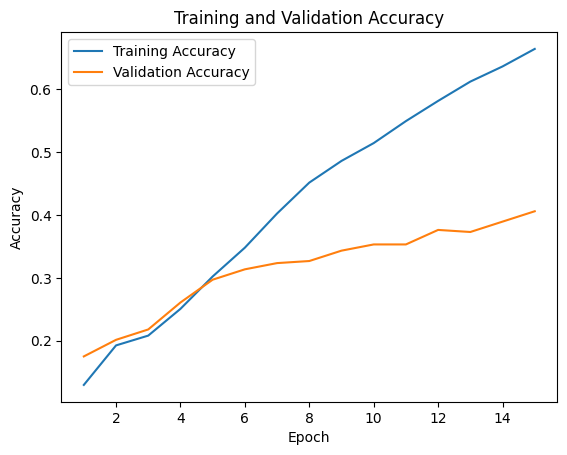

In [ ]:
if False:
    # Plotting training and validation accuracies
    epochs = range(1, len(train_accuracies_pca) + 1)

    plt.plot(epochs, train_accuracies_pca, label='Training Accuracy')
    plt.plot(epochs, val_accuracies_pca, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#### **Ensemble**

##### **interconversions**

In [ ]:
train_pred_knn_tensor, val_pred_knn_tensor, test_pred_knn_tensor = torch.tensor(train_pred_knn), torch.tensor(val_pred_knn), torch.tensor(test_pred_knn)

train_pred_svm_tensor, val_pred_svm_tensor, test_pred_svm_tensor = torch.tensor(train_pred_svm), torch.tensor(val_pred_svm), torch.tensor(test_pred_svm)

train_pred_svm_hog_pca_tensor, val_pred_svm_hog_pca_tensor, test_pred_svm_hog_pca_tensor = torch.tensor(train_pred_svm_hog_pca), torch.tensor(val_pred_svm_hog_pca), torch.tensor(test_pred_svm_hog_pca)

train_pred_svm_lbp_pca_tensor, val_pred_svm_lbp_pca_tensor, test_pred_svm_lbp_pca_tensor = torch.tensor(train_pred_svm_lbp_pca), torch.tensor(val_pred_svm_lbp_pca), torch.tensor(test_pred_svm_lbp_pca)

In [ ]:
train_pred_mlp_array, val_pred_mlp_array, test_pred_mlp_array = train_pred_mlp.cpu().numpy(), val_pred_mlp.cpu().numpy(), test_pred_mlp.cpu().numpy()

train_pred_mlp_resized_array, val_pred_mlp_resized_array, test_pred_mlp_resized_array = train_pred_mlp_resized.cpu().numpy(), val_pred_mlp_resized.cpu().numpy(), test_pred_mlp_resized.cpu().numpy()

train_pred_mlp_hog_array, val_pred_mlp_hog_array, test_pred_mlp_hog_array = train_pred_mlp_hog.cpu().numpy(), val_pred_mlp_hog.cpu().numpy(), test_pred_mlp_hog.cpu().numpy()

train_pred_mlp_hog_pca_array, val_pred_mlp_hog_pca_array, test_pred_mlp_hog_pca_array = train_pred_mlp_hog_pca.cpu().numpy(), val_pred_mlp_hog_pca.cpu().numpy(), test_pred_mlp_hog_pca.cpu().numpy()

train_pred_mlp_lbp_pca_array, val_pred_mlp_lbp_pca_array, test_pred_mlp_lbp_pca_array = train_pred_mlp_lbp_pca.cpu().numpy(), val_pred_mlp_lbp_pca.cpu().numpy(), test_pred_mlp_lbp_pca.cpu().numpy()

##### **RandomForest**

In [ ]:
# Concatenate all prediction vectors
all_train_predictions = np.column_stack((train_pred_knn, train_pred_svm, train_pred_svm_hog_pca, train_pred_svm_lbp_pca, train_pred_mlp_array, 
                                         train_pred_mlp_resized_array, train_pred_mlp_hog_array, train_pred_mlp_hog_pca_array, train_pred_mlp_lbp_pca_array)) 
all_val_predictions = np.column_stack((val_pred_knn, val_pred_svm, val_pred_svm_hog_pca, val_pred_svm_lbp_pca, val_pred_mlp_array, 
                                       val_pred_mlp_resized_array, val_pred_mlp_hog_array, val_pred_mlp_hog_pca_array, val_pred_mlp_lbp_pca_array))
all_test_predictions = np.column_stack((test_pred_knn, test_pred_svm, test_pred_svm_hog_pca, test_pred_svm_lbp_pca, test_pred_mlp_array, 
                                        test_pred_mlp_resized_array, test_pred_mlp_hog_array, test_pred_mlp_hog_pca_array, test_pred_mlp_lbp_pca_array))

# Prepare the Targets
train_labels = y_train_resampled_smote 
val_labels = y_val
test_labels = y_test

In [ ]:
model = RandomForestClassifier() 
model.fit(all_train_predictions, train_labels)

RandomForestClassifier()

In [ ]:
random_forest_ensemble_train_accuracy = model.score(all_train_predictions, train_labels)
print("Train Accuracy:", random_forest_ensemble_train_accuracy)

random_forest_ensemble_val_accuracy = model.score(all_val_predictions, val_labels)
print("Validation Accuracy:", random_forest_ensemble_val_accuracy)

random_forest_ensemble_test_predictions = model.predict(all_test_predictions)

random_forest_ensemble_test_accuracy = model.score(all_test_predictions, test_labels)
print("Test Accuracy:", random_forest_ensemble_test_accuracy)

Train Accuracy: 1.0
Validation Accuracy: 0.49834983498349833
Test Accuracy: 0.5107438016528926


##### **Majority Voting**

In [ ]:
# Calculate the mode (most frequent class label) for each sample
train_ensemble_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=all_train_predictions)
val_ensemble_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=all_val_predictions)
test_ensemble_majority = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=all_test_predictions)

In [ ]:
def calculate_accuracy(predictions, targets):
    correct = (predictions == targets).sum().item()
    total = len(targets)
    accuracy = correct / total
    return accuracy

# Calculate accuracy for train, validation, and test predictions
majority_train_accuracy = calculate_accuracy(train_ensemble_majority, train_labels)
majority_val_accuracy = calculate_accuracy(val_ensemble_majority, val_labels)
majority_test_accuracy = calculate_accuracy(test_ensemble_majority, test_labels)

print("Majority Voting:")
print("Train Accuracy:", majority_train_accuracy)
print("Validation Accuracy:", majority_val_accuracy)
print("Test Accuracy:", majority_test_accuracy)

Majority Voting:
Train Accuracy: 0.9995271867612293
Validation Accuracy: 0.7095709570957096
Test Accuracy: 0.7057851239669422
